# Extreme Deconvolution of Stellar Data

## Figure 6.12

In [1]:
"""
Extreme Deconvolution of Stellar Data
-------------------------------------
Figure 6.12

Extreme deconvolution applied to stellar data from SDSS Stripe 82. The top
panels compare the color distributions for a high signal-to-noise sample of
standard stars (left) with lower signal-to-noise, single epoch, data (right).
The middle panels show the results of applying extreme deconvolution to the
single epoch data. The bottom panel compares the distributions of a color
measured perpendicularly to the locus (the so-called w color is defined
following Ivezic et al 2004). The distribution of colors from the extreme
deconvolution of the noisy data recovers the tight distribution of the high
signal-to-noise data.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general


'\nExtreme Deconvolution of Stellar Data\n-------------------------------------\nFigure 6.12\n\nExtreme deconvolution applied to stellar data from SDSS Stripe 82. The top\npanels compare the color distributions for a high signal-to-noise sample of\nstandard stars (left) with lower signal-to-noise, single epoch, data (right).\nThe middle panels show the results of applying extreme deconvolution to the\nsingle epoch data. The bottom panel compares the distributions of a color\nmeasured perpendicularly to the locus (the so-called w color is defined\nfollowing Ivezic et al 2004). The distribution of colors from the extreme\ndeconvolution of the noisy data recovers the tight distribution of the high\nsignal-to-noise data.\n'

In [2]:
from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from astroML.density_estimation import XDGMM
from astroML.crossmatch import crossmatch
from astroML.datasets import fetch_sdss_S82standards, fetch_imaging_sample
from astroML.plotting.tools import draw_ellipse
from astroML.utils.decorators import pickle_results
from astroML.stats import sigmaG

/Users/dagoret/anaconda3/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [3]:
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

In [4]:
#------------------------------------------------------------
# define u-g-r-i-z extinction from Berry et al, arXiv 1111.4985
# multiply extinction by A_r
extinction_vector = np.array([1.810, 1.400, 1.0, 0.759, 0.561])


In [5]:
#----------------------------------------------------------------------
# Fetch and process the noisy imaging data
data_noisy = fetch_imaging_sample()

# select only stars
data_noisy = data_noisy[data_noisy['type'] == 6]

# Get the extinction-corrected magnitudes for each band
X = np.vstack([data_noisy[f + 'RawPSF'] for f in 'ugriz']).T
Xerr = np.vstack([data_noisy[f + 'psfErr'] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
X -= (extinction_vector * data_noisy['rExtSFD'][:, None])

In [6]:
#----------------------------------------------------------------------
# Fetch and process the stacked imaging data
data_stacked = fetch_sdss_S82standards()

# cut to RA, DEC range of imaging sample
RA = data_stacked['RA']
DEC = data_stacked['DEC']
data_stacked = data_stacked[(RA > 0) & (RA < 10) &
                            (DEC > -1) & (DEC < 1)]

# get stacked magnitudes for each band
Y = np.vstack([data_stacked['mmu_' + f] for f in 'ugriz']).T
Yerr = np.vstack([data_stacked['msig_' + f] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
Y -= (extinction_vector * data_stacked['A_r'][:, None])

# quality cuts
g = Y[:, 1]
mask = ((Yerr.max(1) < 0.05) &
        (g < 20))
data_stacked = data_stacked[mask]
Y = Y[mask]
Yerr = Yerr[mask]


#----------------------------------------------------------------------
# cross-match
#  the imaging sample contains both standard and variable stars.  We'll
#  perform a cross-match with the standard star catalog and choose objects
#  which are common to both.
Xlocs = np.hstack((data_noisy['ra'][:, np.newaxis],
                   data_noisy['dec'][:, np.newaxis]))
Ylocs = np.hstack((data_stacked['RA'][:, np.newaxis],
                   data_stacked['DEC'][:, np.newaxis]))

print("number of noisy points:  ", Xlocs.shape)
print("number of stacked points:", Ylocs.shape)

# find all points within 0.9 arcsec.  This cutoff was selected
# by plotting a histogram of the log(distances).
dist, ind = crossmatch(Xlocs, Ylocs, max_distance=0.9 / 3600)

noisy_mask = (~np.isinf(dist))
stacked_mask = ind[noisy_mask]

# select the data
data_noisy = data_noisy[noisy_mask]
X = X[noisy_mask]
Xerr = Xerr[noisy_mask]

data_stacked = data_stacked[stacked_mask]
Y = Y[stacked_mask]
Yerr = Yerr[stacked_mask]

# double-check that our cross-match succeeded
assert X.shape == Y.shape
print("size after crossmatch:", X.shape)


number of noisy points:   (82003, 2)
number of stacked points: (13377, 2)
size after crossmatch: (12313, 5)


In [7]:
#----------------------------------------------------------------------
# perform extreme deconvolution on the noisy sample

# first define mixing matrix W
W = np.array([[0, 1, 0, 0, 0],    # g magnitude
              [1, -1, 0, 0, 0],   # u-g color
              [0, 1, -1, 0, 0],   # g-r color
              [0, 0, 1, -1, 0],   # r-i color
              [0, 0, 0, 1, -1]])  # i-z color

X = np.dot(X, W.T)
Y = np.dot(Y, W.T)

# compute error covariance from mixing matrix
Xcov = np.zeros(Xerr.shape + Xerr.shape[-1:])
Xcov[:, range(Xerr.shape[1]), range(Xerr.shape[1])] = Xerr ** 2

# each covariance C = WCW^T
# best way to do this is with a tensor dot-product
Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))


In [8]:
#----------------------------------------------------------------------
# This is a long calculation: save results to file
@pickle_results("XD_stellar.pkl")
def compute_XD(n_clusters=12, rseed=0, max_iter=100, verbose=True):
    np.random.seed(rseed)
    clf = XDGMM(n_clusters, max_iter=max_iter, tol=1E-5, verbose=verbose)
    clf.fit(X, Xcov)
    return clf


clf = compute_XD(12)


@pickle_results: computing results and saving to 'XD_stellar.pkl'


/Users/dagoret/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


1: log(L) = 32868
    (11 sec)
2: log(L) = 33422
    (11 sec)
3: log(L) = 33742
    (11 sec)
4: log(L) = 33967
    (11 sec)
5: log(L) = 34155
    (11 sec)
6: log(L) = 34307
    (10 sec)
7: log(L) = 34418
    (10 sec)
8: log(L) = 34507
    (11 sec)
9: log(L) = 34583
    (11 sec)
10: log(L) = 34648
    (12 sec)
11: log(L) = 34707
    (11 sec)
12: log(L) = 34762
    (13 sec)
13: log(L) = 34818
    (11 sec)
14: log(L) = 34884
    (11 sec)
15: log(L) = 34943
    (11 sec)
16: log(L) = 34988
    (11 sec)
17: log(L) = 35028
    (11 sec)
18: log(L) = 35066
    (11 sec)
19: log(L) = 35103
    (11 sec)
20: log(L) = 35138
    (11 sec)
21: log(L) = 35174
    (11 sec)
22: log(L) = 35208
    (11 sec)
23: log(L) = 35242
    (11 sec)
24: log(L) = 35276
    (11 sec)
25: log(L) = 35310
    (11 sec)
26: log(L) = 35342
    (11 sec)
27: log(L) = 35375
    (11 sec)
28: log(L) = 35406
    (11 sec)
29: log(L) = 35436
    (11 sec)
30: log(L) = 35465
    (11 sec)
31: log(L) = 35493
    (11 sec)
32: log(L) = 3551

In [9]:
#------------------------------------------------------------
# Fit and sample from the underlying distribution
np.random.seed(42)
X_sample = clf.sample(X.shape[0])


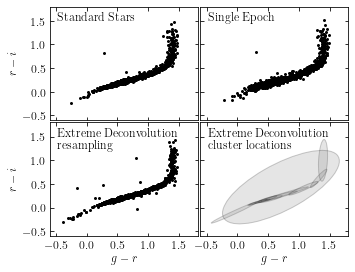

In [10]:
#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(left=0.12, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

# only plot 1/10 of the stars for clarity
ax1 = fig.add_subplot(221)
ax1.scatter(Y[::10, 2], Y[::10, 3], s=9, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(X[::10, 2], X[::10, 3], s=9, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(X_sample[::10, 2], X_sample[::10, 3], s=9, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i, 2:4], clf.V[i, 2:4, 2:4], scales=[2],
                 ec='k', fc='gray', alpha=0.2, ax=ax4)

titles = ["Standard Stars", "Single Epoch",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]
ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-0.6, 1.8)
    ax[i].set_ylim(-0.6, 1.8)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(0.5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$g-r$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$r-i$')


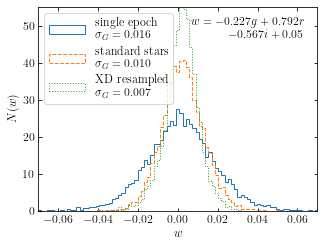

In [11]:
#------------------------------------------------------------
# Second figure: the width of the locus
fig = plt.figure(figsize=(5, 3.75))
ax = fig.add_subplot(111)

labels = ['single epoch', 'standard stars', 'XD resampled']
linestyles = ['solid', 'dashed', 'dotted']
for data, label, ls in zip((X, Y, X_sample), labels, linestyles):
    g = data[:, 0]
    gr = data[:, 2]
    ri = data[:, 3]

    r = g - gr
    i = r - ri

    mask = (gr > 0.3) & (gr < 1.0)
    g = g[mask]
    r = r[mask]
    i = i[mask]

    w = -0.227 * g + 0.792 * r - 0.567 * i + 0.05

    sigma = sigmaG(w)

    ax.hist(w, bins=np.linspace(-0.08, 0.08, 100), linestyle=ls,
            histtype='step', label=label + '\n\t' + r'$\sigma_G=%.3f$' % sigma,
            density=True)

ax.legend(loc=2)
ax.text(0.95, 0.95, '$w = -0.227g + 0.792r$\n$ - 0.567i + 0.05$',
        transform=ax.transAxes, ha='right', va='top')

ax.set_xlim(-0.07, 0.07)
ax.set_ylim(0, 55)

ax.set_xlabel('$w$')
ax.set_ylabel('$N(w)$')

plt.show()
